In [45]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr
import DarkVerse as dv
%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)

In [46]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [47]:
from collections import defaultdict

bias_vs_z = defaultdict(list)  # key: mass_bin str, value: list of (z, b, be)


## Use the SBI outputs!!!

In [ ]:


stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "DES_DF_SN-X3_sbi_output.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "DES_DF_SN-C3_sbi_output.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "DES_DF_SN-E2_sbi_output.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "DES_DF_COSMOS_sbi_output.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    #'nbins': 10,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Fixed redshift range
z_min, z_max = 0.2, 0.5


# Define stellar mass bins

SM_bins = [(10.5, 12.5)]


# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Create a 2x2 subplot grid for the 4 fields
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()  # So we can index axs[0] ... axs[3]

# Initialize the plot index
plot_idx = 0


# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    #first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_catalog.rename_column('mode_z','z')
    first_catalog.rename_column('mode_mass','SM')
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    # Process all fields
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id') # Join masked and catalog
        #catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        catalog.rename_column('mode_z','z')
        catalog.rename_column('mode_mass','SM')
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        
        
        # HOD fitting for this stellar mass bin        
        hod_params, pcov = subsample.fit_hod()
        
        results = subsample.get_results()
        theta = results['theta']
        w_theta = results['w_theta']
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap']))

                
        ax = axs[plot_idx]
        plot_idx += 1
        
        ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label=field)
        
        logM_min, logM_1, alpha = results['hod_params']
        w_model = subsample.hod_model(logM_min * 1e7, logM_1, alpha)
        xi_m_values = subsample.get_results()['xi_m']
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')
        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([1e-4, 10])
        ax.set_title(field)
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(fontsize=8)
        
        # Set axis labels based on subplot position
       # if plot_idx // 2 == 1:  # Bottom row -> x-axis label
            #ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
        #if plot_idx % 2 == 0:   # Left column -> y-axis label
            #ax.set_ylabel(r'$w(\theta)$', fontsize=12)

        ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
        ax.set_ylabel(r'$w(\theta)$', fontsize=12)
        # Optional annotations
        ax.text(0.2, 0.9, "1-halo", transform=ax.transAxes, color='gray', fontsize=9)
        ax.text(0.6, 0.9, "2-halo", transform=ax.transAxes, color='gray', fontsize=9)
        

        
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        

    
            
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")
            
        estimator.add_field(
                field_name=field,
                xi_g=np.array(results['xi_g']),
                w_theta=np.array(results['w_theta']),
                w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
                sum_rr=np.array(results['rr_counts'])
            )
            
           
                
    plt.suptitle(
        fr"$w(\theta)$ for $10^{{{SM_min}}} < M_* $, $z \in [{z_min},{z_max}]$",

        fontsize=16
    )


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"wtheta_4fields_SM_{SM_min}_{z_min}.png")
    plt.show()
    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict,
        'logM_min': logM_min 
    }




🔹 Processing stellar mass bin 10.5–12.5


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)



🔸 Processing field: SN-X3
HOD fit results: M_min = 10^12.10, M_1 = 10^13.28, alpha = 1.15
  ➤ bias_eff = 1.388

🔸 Processing field: SN-C3


The following patch numbers have no objects: {46}
This may be a problem depending on your use case.
The following patch numbers have no objects: {45}
This may be a problem depending on your use case.
HOD fit results: M_min = 10^11.98, M_1 = 10^13.37, alpha = 1.01
  ➤ bias_eff = 1.234

🔸 Processing field: SN-E2
The following patch numbers have no objects: {9}
This may be a problem depending on your use case.
HOD fit results: M_min = 10^13.36, M_1 = 10^15.20, alpha = 1.34
  ➤ bias_eff = 2.187

🔸 Processing field: COSMOS


In [ ]:


z_bins = [
  #  (0.0, 0.2),
    (0.2, 0.4),
    (0.4, 0.6),
    (0.6, 0.8),
    (0.8, 1.0),
]

sm_thresholds = {
   # (0.0, 0.2): [8.00, 9.00, 10.00],
    (0.2, 0.4): [9.00, 10.00],
    (0.4, 0.6): [9.00, 10.00],
    (0.6, 0.8): [10.00],
    (0.8, 1.0): [10.00],
}

fields = {
    "SN-X3": {
        "catalog": "DES_DF_SN-X3_sbi_output.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "DES_DF_SN-C3_sbi_output.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "DES_DF_SN-E2_sbi_output.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "DES_DF_COSMOS_sbi_output.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')


def load_and_prepare_catalog(field_name, paths, thesis_path):
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))
    catalog = join(catalog, masked, keys='id')
    catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
    return catalog, randoms

# MAIN LOOP

from collections import defaultdict
all_results = defaultdict(dict)

for z_min, z_max in z_bins:
    if (z_min, z_max) not in sm_thresholds:
        continue
    
    thresholds = sm_thresholds[(z_min, z_max)]
    if len(thresholds) < 2:
        continue
    
    SM_bins = [(thresholds[i], thresholds[i + 1]) for i in range(len(thresholds) - 1)]

    for SM_min, SM_max in SM_bins:
        print(f"\n\n🔹 Processing z bin [{z_min}, {z_max}] and stellar mass bin [{SM_min}, {SM_max}]")

        fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
        axs = axs.flatten()
        plot_idx = 0

        first_field = list(fields.keys())[0]
        first_catalog, first_randoms = load_and_prepare_catalog(first_field, fields[first_field], thesis_path)

        first_subsample = dv.Selection(
            catalog=first_catalog,
            randoms=first_randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        first_results = first_subsample.get_results()

        estimator = dv.FieldBiasEstimator(
            xi_m=np.array(first_results['xi_m']),
            mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
        )

        bias_eff_dict = {}

        for field_name, paths in fields.items():
            print(f"\n🔸 Processing field: {field_name}")
            catalog, randoms = load_and_prepare_catalog(field_name, paths, thesis_path)

            subsample = dv.Selection(
                catalog=catalog,
                randoms=randoms,
                z_min=z_min,
                z_max=z_max,
                SM_min=SM_min,
                SM_max=SM_max,
                config=config
            )

            hod_params, pcov = subsample.fit_hod()
            results = subsample.get_results()

            theta = results['theta']
            w_theta = results['w_theta']
            w_theta_error = np.sqrt(np.array(results['var_w_theta_bootstrap']))

            ax = axs[plot_idx]
            plot_idx += 1

            ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label=field_name)

            logM_min, logM_1, alpha = results['hod_params']
            w_model = subsample.hod_model(logM_min * 1e7, logM_1, alpha)

            ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim([1e-4, 10])
            ax.set_title(field_name)
            ax.grid(True, which="both", ls="--", alpha=0.3)
            ax.legend(fontsize=8)

            if plot_idx // 2 == 1:
                ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
            if plot_idx % 2 == 0:
                ax.set_ylabel(r'$w(\theta)$', fontsize=12)

            ax.text(0.2, 0.9, "1-halo", transform=ax.transAxes, color='gray', fontsize=9)
            ax.text(0.6, 0.9, "2-halo", transform=ax.transAxes, color='gray', fontsize=9)

            print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
                  f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

            bias_eff = subsample.gg.bias_effective_tracer
            bias_eff_dict[field_name] = bias_eff
            print(f"  ➤ bias_eff = {bias_eff:.3f}")

            estimator.add_field(
                field_name=field_name,
                xi_g=np.array(results['xi_g']),
                w_theta=np.array(results['w_theta']),
                w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
                sum_rr=np.array(results['rr_counts'])
            )

        plt.suptitle(
            fr"$w(\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$",
            fontsize=16
        )
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"wtheta_{z_min}_{z_max}_SM_{SM_min}_{SM_max}.png")
        plt.show()

        print("\nIndividual Field Results:")
        individual_results = estimator.fit_individual_fields()
        for name, b, be, ic in individual_results:
            print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")

        global_b, global_be = estimator.fit_combined()
        print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")

        all_results[(z_min, z_max)][(SM_min, SM_max)] = {
            'individual': individual_results,
            'global_b': global_b,
            'global_be': global_be,
            'estimator': estimator,
            'bias_eff': bias_eff_dict,
            'logM_min': logM_min
        }


In [ ]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    'nbins': 10,
    #'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}


# Initialize storage
#all_results = {sm_range: {} for sm_range in SM_bins}
all_results = {}



z_bins = [
    #(0.0, 0.2),
    (0.2, 0.4),
    (0.4, 0.6),
    (0.6, 0.8),
    (0.8, 1.0),
]

sm_thresholds = {
    #(0.0, 0.2): [8.00, 9.00, 10.00],
    (0.2, 0.4): [9.00, 10.00, ],
    (0.4, 0.6): [9.00, 10.00 ],
    (0.6, 0.8): [10.00 ],
    (0.8, 1.0): [10.00],
}

for z_key in sm_thresholds:
    if sm_thresholds[z_key][-1] < 12.5:
        sm_thresholds[z_key].append(12.5)

for z_min, z_max in z_bins:
    sm_list = sm_thresholds[(z_min, z_max)]
    sm_bins = [(sm_list[i], sm_list[i + 1]) for i in range(len(sm_list) - 1)]

    for SM_min, SM_max in sm_bins:
        print(f"\n🔍 Processing: z ∈ [{z_min}, {z_max}], logM* ∈ [{SM_min}, {SM_max}]")

        first_field = list(fields.keys())[0]
        first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
        first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
        first_catalog = join(first_catalog, first_masked, keys='id')
        first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
        
        first_subsample = dv.Selection(
            catalog=first_catalog,
            randoms=first_randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        first_results = first_subsample.get_results()
        
        estimator = dv.FieldBiasEstimator(
            xi_m=np.array(first_results['xi_m']),
            mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
        )
        
        bias_eff_dict = {}
    
        # Process all fields
        for field, paths in fields.items():
            print(f"\n🔸 Processing field: {field}")
            
            catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
            masked = Table.read(os.path.join(thesis_path, paths["masked"]))
            catalog = join(catalog, masked, keys='id') # Join masked and catalog
            catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
            randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
            
            subsample = dv.Selection(
                catalog=catalog,
                randoms=randoms,
                z_min=z_min,
                z_max=z_max,
                SM_min=SM_min,
                SM_max=SM_max,
                config=config
            )
    
    
            
            # HOD fitting for this stellar mass bin        
            hod_params, pcov = subsample.fit_hod()
            
            results = subsample.get_results()
            theta = results['theta']
            w_theta = results['w_theta']
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap']))
    
    
    
            #ax.errorbar(theta, w_theta, yerr=w_theta_error, fmt='o', label=field)
            
            logM_min, logM_1, alpha = results['hod_params']
            w_model = subsample.hod_model(logM_min * 1e7, logM_1, alpha)
    
            xi_m_values = subsample.get_results()['xi_m']
            #ax.plot(theta, xi_m_values, label=r'$\omega_{\mathrm{dm}}(\theta)$', linestyle='dashed', color='black')
            # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')
            #ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
            
           
            bias_eff = subsample.gg.bias_effective_tracer
            bias_eff_dict[field] = bias_eff
            print(f"  ➤ bias_eff = {bias_eff:.3f}")
    
    
            
            estimator.add_field(
                field_name=field,
                xi_g=np.array(results['xi_g']),
                w_theta=np.array(results['w_theta']),
                w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
                sum_rr=np.array(results['rr_counts'])
            )
            
            # Compute stellar-to-halo mass ratio
            logM_star = SM_min  # log stellar mass threshold
            logM_halo = logM_min *1e7  # From HOD fit
            M_star = 10**logM_star
            M_halo = 10**logM_halo
            stellar_masses.append(M_star)
            halo_masses.append(M_halo)
            
    
    
        
        print("\nIndividual Field Results:")
        individual_results = estimator.fit_individual_fields()
        global_b, global_be = estimator.fit_combined()
        
        print(f"  ➤ Global bias: b = {global_b:.3f} ± {global_be:.3f}")
        
        # Store for plotting
        z_mid = 0.5 * (z_min + z_max)
        mass_bin_label = f"{SM_min:.1f}–{SM_max:.1f}"
        bias_vs_z[mass_bin_label].append((z_mid, global_b, global_be))


        
        for name, b, be, ic in individual_results:
            print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
        
       
        
        all_results[(SM_min, SM_max)] = {
            'individual': individual_results,
            'global_b': global_b,
            'global_be': global_be,
            'estimator': estimator,
            'bias_eff': bias_eff_dict,
            'logM_min': logM_min 
        }
    


# Plot ACF for same SM range and diff. z

In [54]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

stellar_masses = []
halo_masses = []

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    'nbins': 10,
    #'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}


# Initialize storage
#all_results = {sm_range: {} for sm_range in SM_bins}
all_results = {}



z_bins = [
    #(0.0, 0.2),
   # (0.2, 0.4),
    (0.4, 0.6),
    (0.6, 0.8),
    (0.8, 1.0),
]



SM_bins = [(10.5, 12.5)]

colors = ["blue", "green", "red", "purple", "orange"]


The following patch numbers have no objects: {19}
This may be a problem depending on your use case.
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


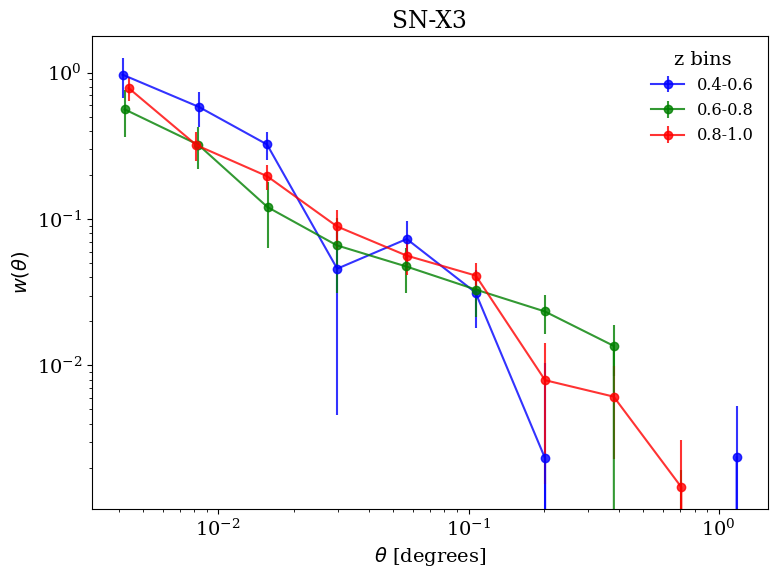

The following patch numbers have no objects: {30}
This may be a problem depending on your use case.
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
The following patch numbers have no objects: {41}
This may be a problem depending on your use case.
The following patch numbers have no objects: {25}
This may be a problem depending on your use case.
The following patch numbers have no objects: {25}
This may be a problem depending on your use case.


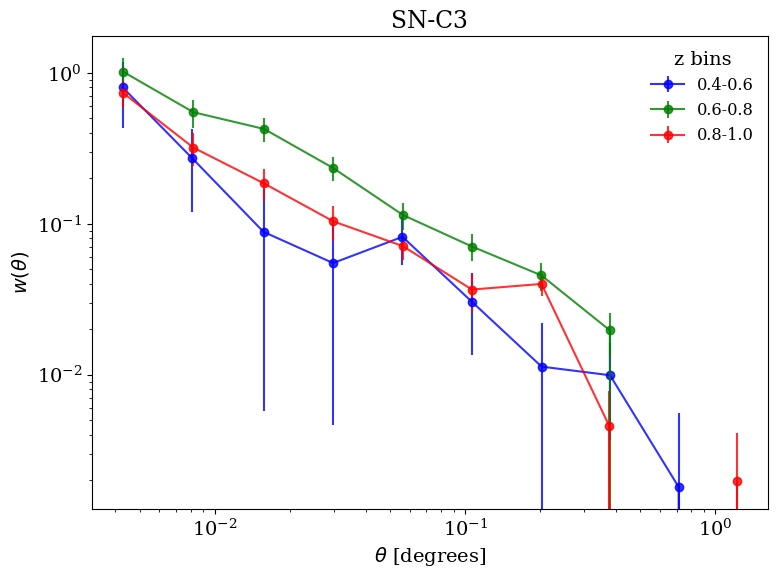

The following patch numbers have no objects: {8}
This may be a problem depending on your use case.
The following patch numbers have no objects: {41}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {10}
This may be a problem depending on your use case.
The following patch numbers have no objects: {41}
This may be a problem depending on your use case.
The following patch numbers have no objects: {41}
This may be a problem depending on your use case.
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
The following patch numbers have no objects: {41}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {43}
This may be a problem depending on your use case.
T

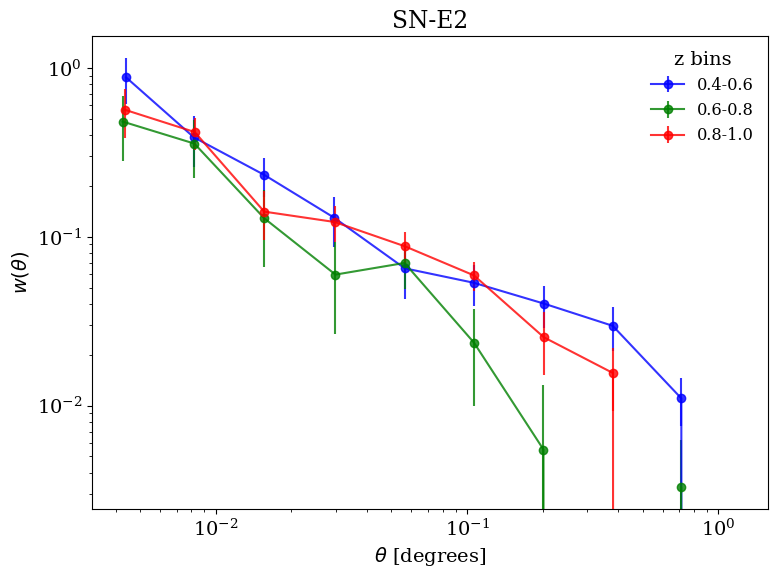

In [ ]:

# For each field, plot w(theta) vs theta for all redshift bins
for field_name, paths in fields.items():
    plt.figure(figsize=(8,6))
    
    # Loop over redshift bins
    for (z_min, z_max), color in zip(z_bins, colors):
        # Load catalog, mask, randoms for this field
        cat = Table.read(os.path.join(thesis_path, paths['catalog']))
        msk = Table.read(os.path.join(thesis_path, paths['masked']))
        cat = join(cat, msk, keys='id')
        cat.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        rnd = Table.read(os.path.join(thesis_path, paths['randoms']))

        # Selection and results
        subs = dv.Selection(
            catalog=cat,
            randoms=rnd,
            z_min=z_min, z_max=z_max,
            SM_min=SM_min, SM_max=SM_max,
            config=config
        )
        res = subs.get_results()

        theta    = np.array(res['theta'])
        wtheta   = np.array(res['w_theta'])
        wtheta_e = np.sqrt(np.array(res['var_w_theta_bootstrap']))

        # Plot w(theta) with error bars
        plt.errorbar(theta, wtheta, yerr=wtheta_e, fmt='-o',
                     color=color, label=f'{z_min:.1f}-{z_max:.1f}', alpha=0.8)

    # Formatting per field
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\theta$ [degrees]')
    plt.ylabel(r'$w(\theta)$')
    plt.title(f'{field_name}')
    plt.legend(title='z bins', frameon=False, fontsize='small')
    plt.tight_layout()
    plt.show()


In [ ]:

plt.figure(figsize=(8, 6))

for mass_bin, values in bias_vs_z.items():
    # Sort by redshift
    values = sorted(values, key=lambda x: x[0])
    z_vals, b_vals, b_errs = zip(*values)
    
    plt.errorbar(z_vals, b_vals, yerr=b_errs, fmt='o-', capsize=3, label=f"logM* ∈ [{mass_bin}]")

plt.xlabel("Redshift $z$")
plt.ylabel("Effective Bias $b_{eff}$")
plt.title("Effective Galaxy Bias vs. Redshift")
plt.grid(True, alpha=0.3)
plt.legend(title="Stellar Mass Bin")
plt.tight_layout()
plt.savefig("bias_vs_redshift.png")
plt.show()
